Survival Outcome of Passengers on the Titanic using ML models

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import shap

In [ ]:


# Step 1: Load and Explore Data
# Load the dataset
df = pd.read_csv('/content/Titanic-Dataset.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Summary Statistics:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.5230

In [ ]:


# Step 1: Load and Explore Data
# Load the dataset
df = pd.read_csv('/content/Titanic-Dataset.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Summary Statistics:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.5230

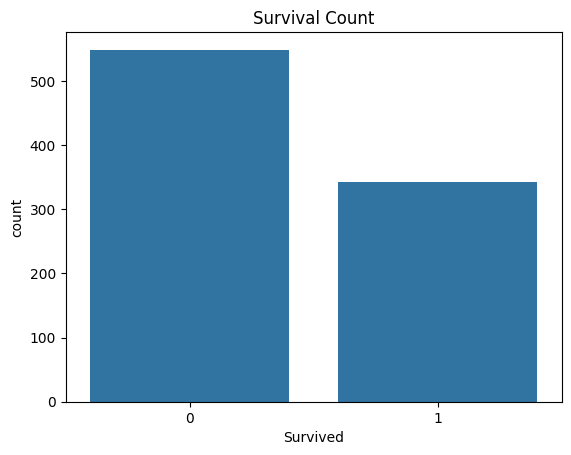

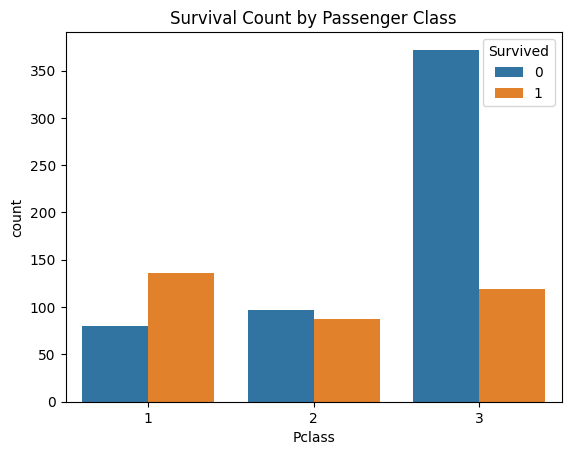

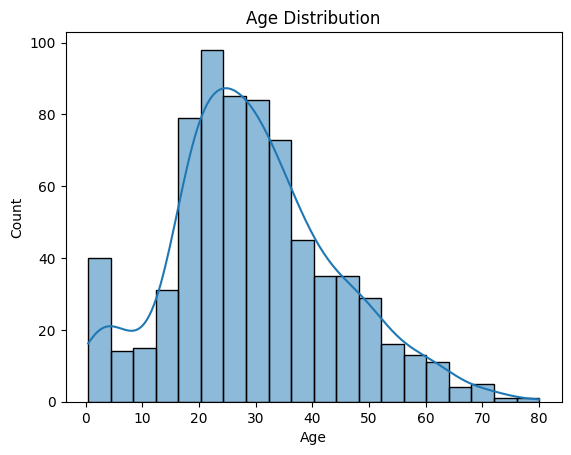

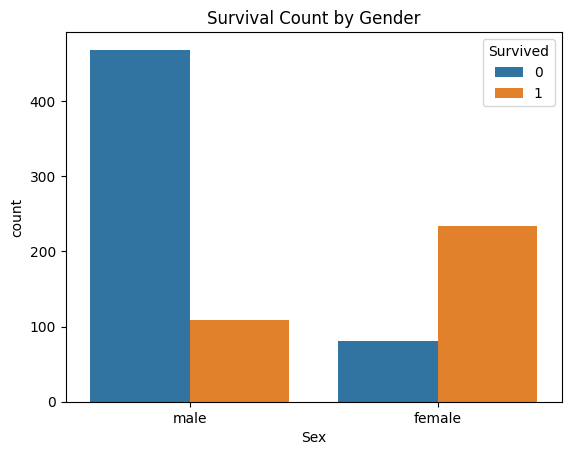

In [ ]:

# Visualize feature distributions and relationships with survival
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')
plt.show()

sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival Count by Passenger Class')
plt.show()

sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival Count by Gender')
plt.show()

In [ ]:


# Step 2: Data Preprocessing
# Handle missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)


<ipython-input-10-2212ebd7f7a2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-10-2212ebd7f7a2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:

# Drop unnecessary columns (but keep 'SibSp' and 'Parch' for feature engineering)
df.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [ ]:

# Step 3: Feature Engineering
# Create a new feature: Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create a new feature: Is Alone
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

# Drop original SibSp and Parch columns
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)


In [ ]:


# Feature scaling
scaler = StandardScaler()
df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])

# Step 4: Model Selection & Training
# Split the dataset into training and testing sets
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:


# Compare different models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy: {accuracy_score(y_test, y_pred)}')

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Logistic Regression Accuracy: 0.7988826815642458
Decision Tree Accuracy: 0.770949720670391
Random Forest Accuracy: 0.8212290502793296
XGBoost Accuracy: 0.7821229050279329
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:


# Step 5: Model Evaluation
# Evaluate the best model
y_pred = best_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.8324022346368715
Precision: 0.84375
Recall: 0.7297297297297297
F1-Score: 0.782608695652174
AUC-ROC: 0.8172458172458174


In [ ]:


# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores)}')

Cross-Validation Accuracy: 0.8227041616973197


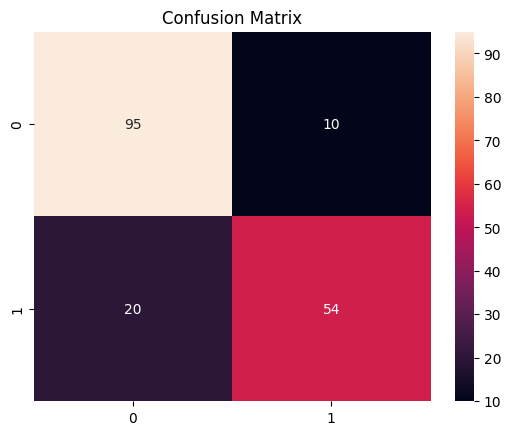

In [ ]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


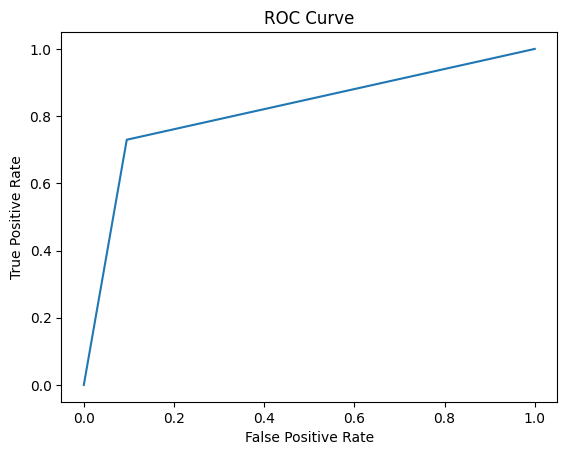

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


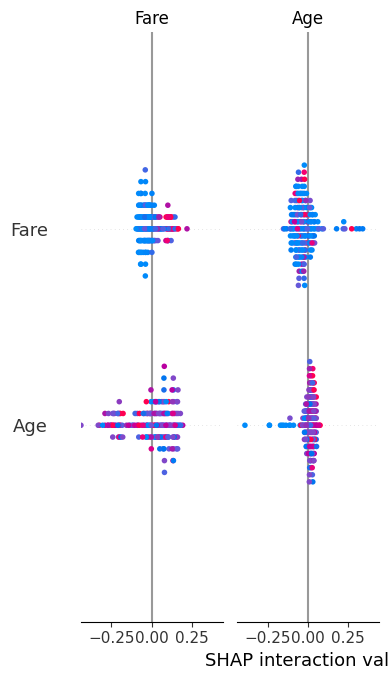

In [ ]:
# Step 6: Predictions & Insights
# Feature Importance using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:

# Insights
feature_importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(importance_df)

Feature Importances:
      Feature  Importance
4    Sex_male    0.380539
1        Fare    0.215571
0         Age    0.170946
8    Pclass_3    0.101572
2  FamilySize    0.068396
6  Embarked_S    0.020993
7    Pclass_2    0.017006
3     IsAlone    0.015106
5  Embarked_Q    0.009871
